In [3]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

In [20]:
df = pd.read_csv("NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)

In [21]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [22]:
def check_df(df):
    print("##################### Shape #####################")
    print(df.shape)
    print("\n##################### Columns #####################")
    print(df.columns)
    print("\n##################### Info #####################")
    df.info()
    print("##################### Types #####################")
    print(df.dtypes)
    print("##################### Head #####################")
    print(df.head())
    print("##################### Tail #####################")
    print(df.tail())
    print("##################### NA #####################")
    print(df.isnull().sum())

check_df(df)

##################### Shape #####################
(6116, 7)

##################### Columns #####################
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6116 non-null   datetime64[ns]
 1   Open       6116 non-null   float64       
 2   High       6116 non-null   float64       
 3   Low        6116 non-null   float64       
 4   Close      6116 non-null   float64       
 5   Adj Close  6116 non-null   float64       
 6   Volume     6116 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 334.6 KB
##################### Types #####################
Date         datetime64[ns]
Open                float64
High                float64
Low             

In [23]:
## data statistics ##
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,6116,6116.000000,6116.000000,6116.000000,6116.000000,6116.000000,6.116000e+03
mean,2012-02-28 11:27:16.363636480,53.052266,54.017201,52.031700,53.064741,52.794253,6.221933e+07
min,2000-01-03 00:00:00,0.608333,0.656667,0.600000,0.614167,0.563377,4.564400e+06
25%,2006-02-01 18:00:00,2.959688,3.027500,2.875000,2.950391,2.707880,3.615840e+07
50%,2012-02-28 12:00:00,4.683750,4.747500,4.608750,4.682500,4.389289,5.206235e+07
75%,2018-03-27 06:00:00,42.101873,42.645625,41.500000,42.102499,41.741090,7.465490e+07
max,2024-04-24 00:00:00,958.510010,974.000000,935.099976,950.020020,950.020020,9.230856e+08
std,NaN,121.267334,123.423982,118.835114,121.183234,121.214864,4.316714e+07


In [24]:
#### Univarite Variable

def column_detection(dataframe: pd.DataFrame, cat_th: int = 10, car_th: int = 20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                       df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                    df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print("\n##################### Categoric #####################")
    print(cat_cols)
    print("\n##################### Numeric #####################")
    print(num_cols)
    print("\n##################### Categoric But Cardinal #####################")
    print(cat_but_car)
    print("\n##################### Numeric But Categoric #####################")
    print(num_but_cat)
    print("\n##################### Columns Overview #####################")
    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [25]:
cat_cols, num_cols, cat_but_car, num_but_cat = column_detection(df)


##################### Categoric #####################
[]

##################### Numeric #####################
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

##################### Categoric But Cardinal #####################
[]

##################### Numeric But Categoric #####################
[]

##################### Columns Overview #####################
Observations: 6116
Variables: 7
cat_cols: 0
num_cols: 7
cat_but_car: 0
num_but_cat: 0


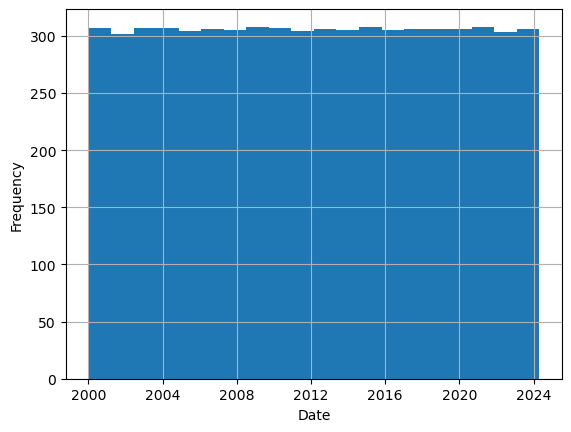

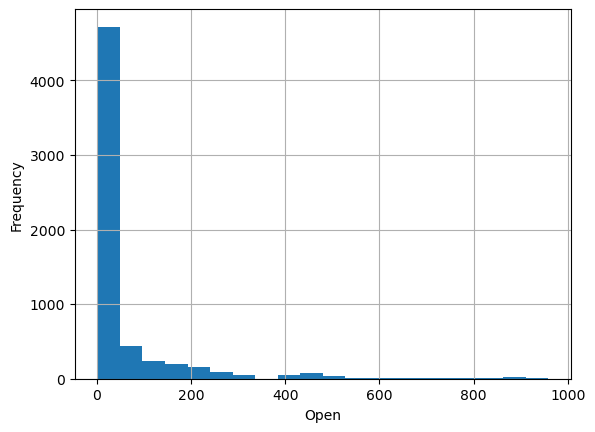

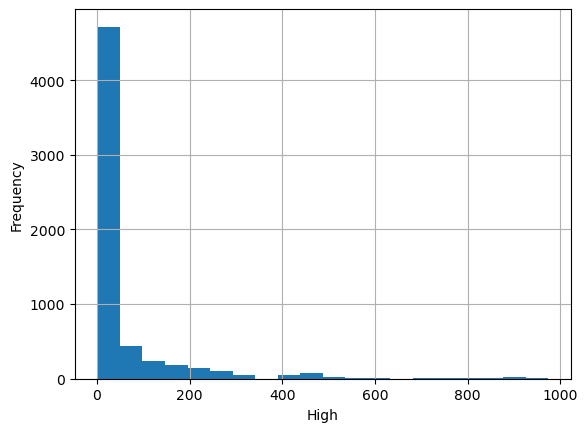

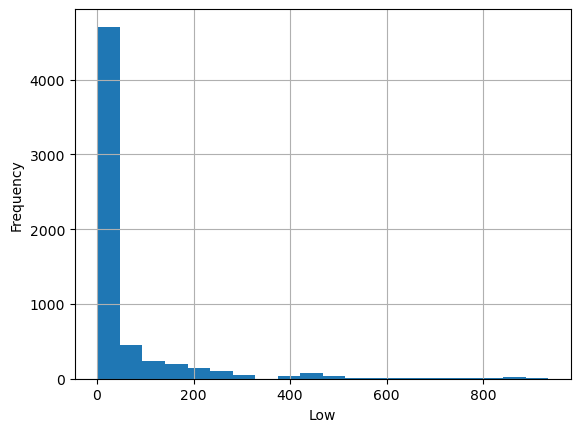

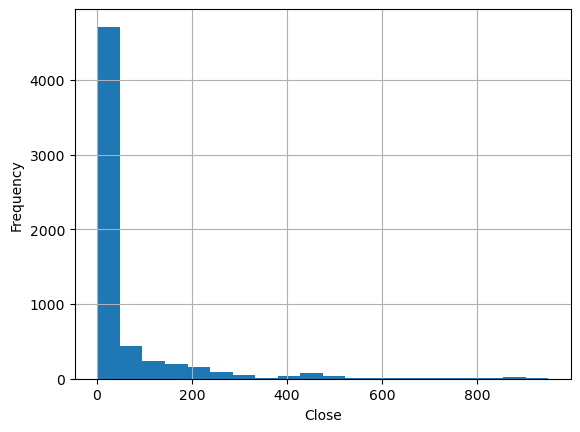

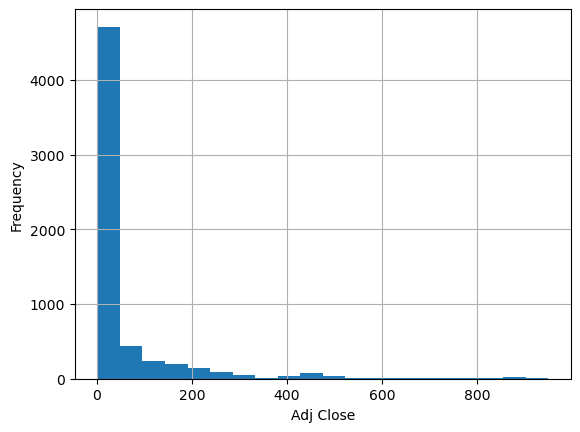

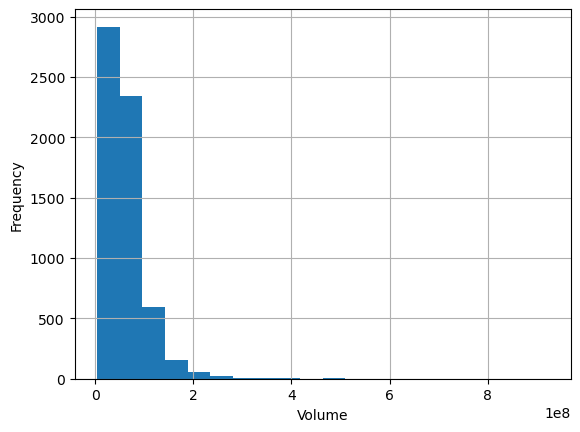

In [26]:
def cat_summary(df, col_name, plot=True):
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))

    if plot:
        sns.countplot(x=df[col_name], data=df)
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col)


def hist_num_columns_show(df, num_column):
    df[num_column].hist(bins=20)
    plt.xlabel(num_column)
    plt.ylabel("Frequency")
    plt.show(block=True)


for num_col in num_cols:
    hist_num_columns_show(df, num_col)

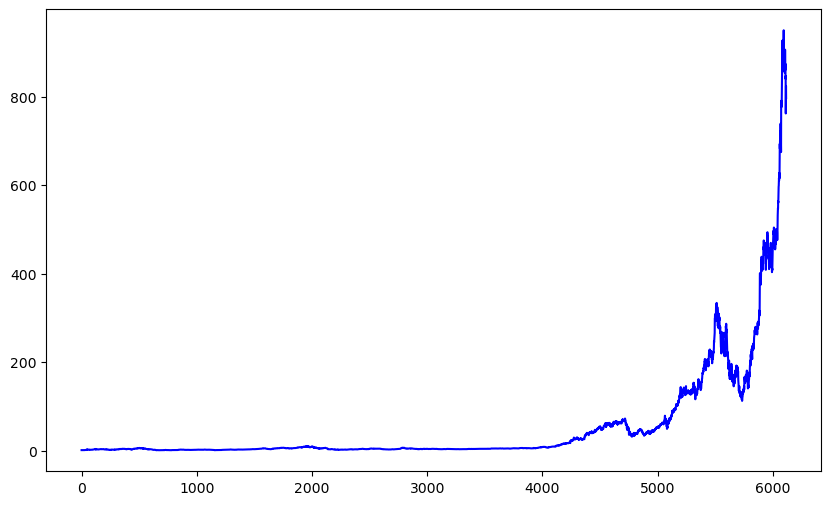

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='blue')

In [28]:
monthvise= df.groupby(df['Date'].dt.strftime('%B'))[['Open','Close','Low','High']].mean()
monthsort= df.groupby(df['Date'].dt.strftime('%B'))[['Open','Close','Low','High']].mean().sort_values(by='Close')
monthvise

,Open,Close,Low,High
Date,,,,
April,66.013187,65.571917,64.464209,67.081862
August,49.447074,49.513534,48.526833,50.350168
December,54.048828,53.953962,53.012579,54.856716
February,64.393898,64.571119,63.110134,65.758041
January,55.028557,55.223957,54.027632,56.132832
July,45.498201,45.532563,44.762818,46.200914
June,44.039314,44.105209,43.304084,44.818446
March,69.060984,69.152373,67.539918,70.561786
May,38.202963,38.301326,37.467343,39.006078


In [29]:
monthsort

,Open,Close,Low,High
Date,,,,
May,38.202963,38.301326,37.467343,39.006078
June,44.039314,44.105209,43.304084,44.818446
July,45.498201,45.532563,44.762818,46.200914
October,47.222969,47.255780,46.411889,48.044548
September,48.433340,48.304540,47.557102,49.131510
August,49.447074,49.513534,48.526833,50.350168
December,54.048828,53.953962,53.012579,54.856716
November,54.872977,54.922520,53.850511,55.876140
January,55.028557,55.223957,54.027632,56.132832


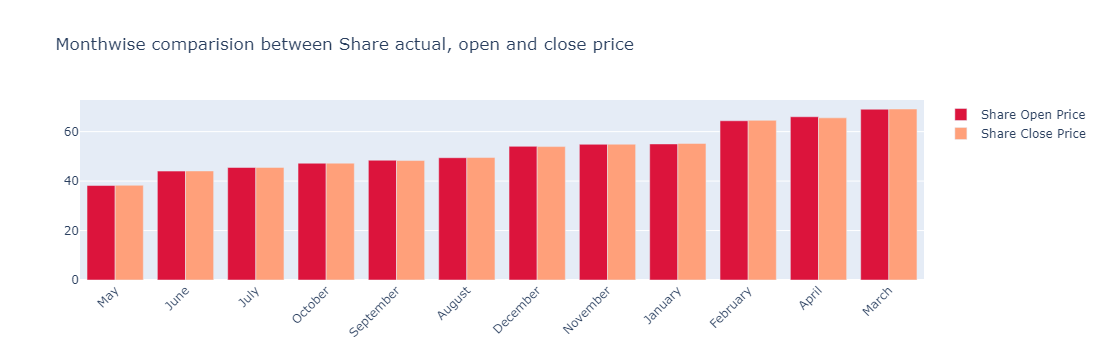

In [42]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthsort.index,
    y=monthsort['Open'],
    name='Share Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthsort.index,
    y=monthsort['Close'],
    name='Share Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Share actual, open and close price')
fig.show()

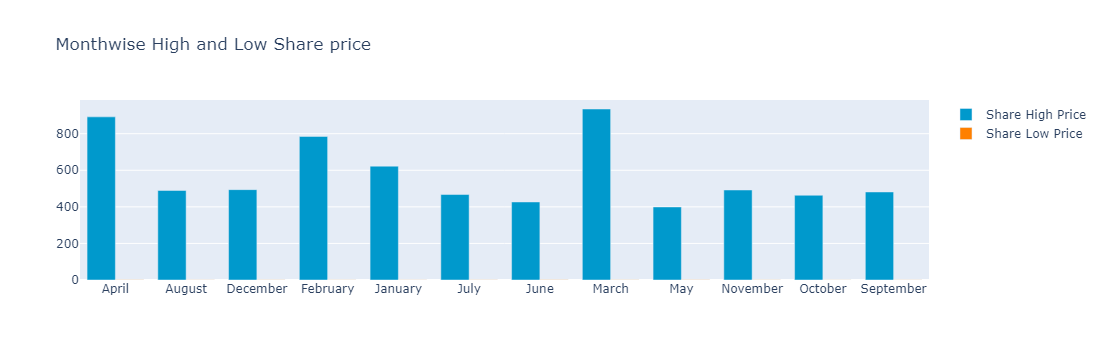

In [43]:
monthvise_high = df.groupby(df['Date'].dt.strftime('%B'))['Low'].max()
monthvise_low = df.groupby(df['Date'].dt.strftime('%B'))['Low'].min()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Share High Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Share Low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Share price')
fig.show()